# Финальный проект. Промышленность

## Постановка задачи

### Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:  
  
* **data_arc.csv** — данные об электродах;
* **data_bulk.csv** — данные о подаче сыпучих материалов (объём);
* **data_bulk_time.csv** — данные о подаче сыпучих материалов (время);
* **data_gas.csv** — данные о продувке сплава газом;
* **data_temp.csv** — результаты измерения температуры;
* **data_wire.csv** — данные о проволочных материалах (объём);
* **data_wire_time.csv** — данные о проволочных материалах (время).  
  
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### План проекта

* Провести исследование и предобработку данных таблиц:
    * Изучить общую информацию о данных таблиц
    * Построить и изучить графики
    * Удалить аномальные значения (если они есть)
    * Заполнить пропуски (если они есть)
    * Очистить данные от ненужной информации, которая не пригодится для обучения модели
    * Объединить данные в одну таблицу (чтобы в дальнейшем обучить модель)
    * Проверить данные на мультиколлинеарность
* Разделить данные на тренировочную и тестовую выборки.
* Обучить модель
* Проанализировать результаты обучения и выбрать подходящую модель для проверки
* Провести анализ важности факторов у лучшей модели
* Проверить модель на тестовой выборке
* Сделать выводы

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Исследовательский анализ данных таблиц

### Загрузка данных

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')  
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')  
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')  
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')  
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')  
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')  
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') 

### Изучение общей информации и предобработка данных

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 14876 entries, 0 to 14875

Data columns (total 5 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   key                   14876 non-null  int64  

 1   Начало нагрева дугой  14876 non-null  object 

 2   Конец нагрева дугой   14876 non-null  object 

 3   Активная мощность     14876 non-null  float64

 4   Реактивная мощность   14876 non-null  float64

dtypes: float64(2), int64(1), object(2)

memory usage: 581.2+ KB


In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Пропусков нет, однако, у двух столбцов неправильный тип данных. Изменим его

In [5]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [6]:
#Проверим изменения
data_arc.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 14876 entries, 0 to 14875

Data columns (total 5 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   key                   14876 non-null  int64         

 1   Начало нагрева дугой  14876 non-null  datetime64[ns]

 2   Конец нагрева дугой   14876 non-null  datetime64[ns]

 3   Активная мощность     14876 non-null  float64       

 4   Реактивная мощность   14876 non-null  float64       

dtypes: datetime64[ns](2), float64(2), int64(1)

memory usage: 581.2 KB


In [7]:
#Проверим наличие дубликатов
data_arc.duplicated().sum()

0

In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В минимуме реактивной мощности явно присутствуют выбросы

Text(0.5, 0, 'Мощность')

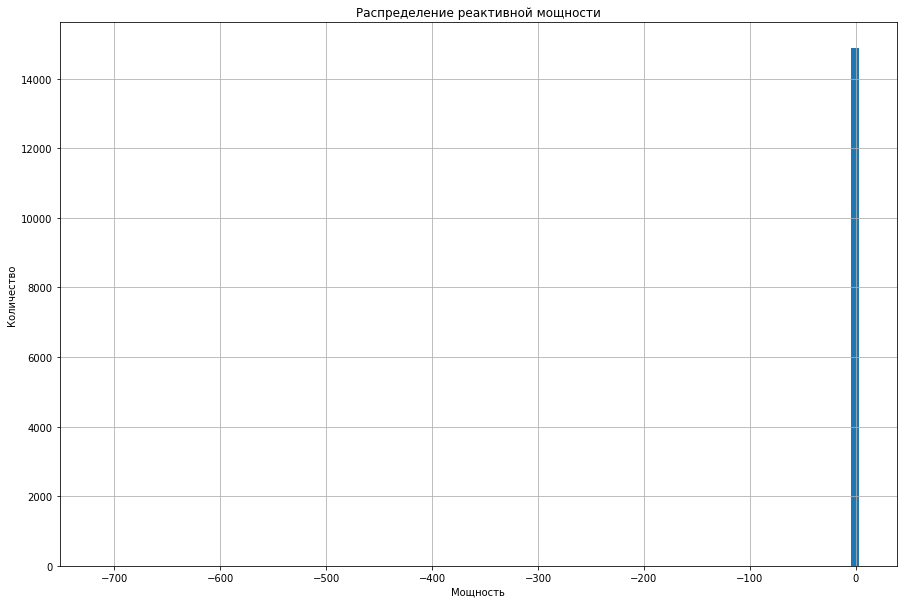

In [9]:
rp = data_arc['Реактивная мощность'].hist(bins=100, figsize=(15, 10))
rp.set_title('Распределение реактивной мощности')
rp.set_ylabel('Количество')
rp.set_xlabel('Мощность')

Все значения расположены около 0. Отсортируем значения в столбце "Реактивная мощность" по возрастанию и выведем на экран 5 первых значений.

In [10]:
data_arc.sort_values(by=['Реактивная мощность']).head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983


Минусовое значение только одно, поэтому оно незаметно на графике. Посмотрим всю партию.

In [11]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Строка с выбросом не последняя в партии, поэтому удалим эту строку с выбросом.

In [12]:
data_arc = data_arc[data_arc['Реактивная мощность'] >=0]

<AxesSubplot:>

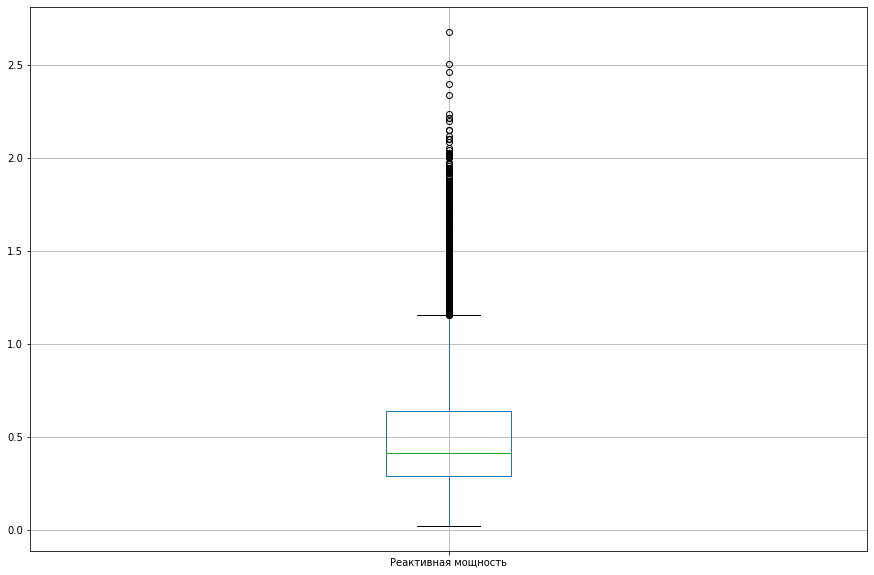

In [13]:
#Посмотрим на изменения, построив график усов
data_arc.boxplot('Реактивная мощность', figsize=(15, 10))

Выброса нет, можно идти дальше

In [14]:
#Рассчитаем полную мощность
data_arc['Полная мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** (0.5)

In [15]:
#Рассчитаем время нагрева в секундах
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])
data_arc['Время нагрева'] = data_arc['Время нагрева'].apply(pd.Timedelta.total_seconds).astype('int')

In [16]:
#Оставим в таблице только ключ, время нагрева и полную мощность
new_data_arc = data_arc.groupby('key').sum()[['Полная мощность', 'Время нагрева']].reset_index()

In [17]:
#Посмотрим новую таблицу
new_data_arc

,key,Полная мощность,Время нагрева
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869
...,...,...,...
3209,3237,4.844982,909
3210,3238,2.696542,546
3211,3239,5.611883,1216
3212,3240,3.891856,839


In [18]:
#Переименуем столбцы
new_data_arc.columns = ['key', 'power_full', 'heating_time']
new_data_arc

,key,power_full,heating_time
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869
...,...,...,...
3209,3237,4.844982,909
3210,3238,2.696542,546
3211,3239,5.611883,1216
3212,3240,3.891856,839


Данные по мощностям обработали, переходим к следующей таблице.

In [19]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3129 entries, 0 to 3128

Data columns (total 16 columns):

 #   Column   Non-Null Count  Dtype  

---  ------   --------------  -----  

 0   key      3129 non-null   int64  

 1   Bulk 1   252 non-null    float64

 2   Bulk 2   22 non-null     float64

 3   Bulk 3   1298 non-null   float64

 4   Bulk 4   1014 non-null   float64

 5   Bulk 5   77 non-null     float64

 6   Bulk 6   576 non-null    float64

 7   Bulk 7   25 non-null     float64

 8   Bulk 8   1 non-null      float64

 9   Bulk 9   19 non-null     float64

 10  Bulk 10  176 non-null    float64

 11  Bulk 11  177 non-null    float64

 12  Bulk 12  2450 non-null   float64

 13  Bulk 13  18 non-null     float64

 14  Bulk 14  2806 non-null   float64

 15  Bulk 15  2248 non-null   float64

dtypes: float64(15), int64(1)

memory usage: 391.2 KB


In [20]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Пропусков много, они скорее всего означают, что сыпучий материал не добавлялся.

In [21]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


На первый взгляд аномальных значений в данных нет

<AxesSubplot:>

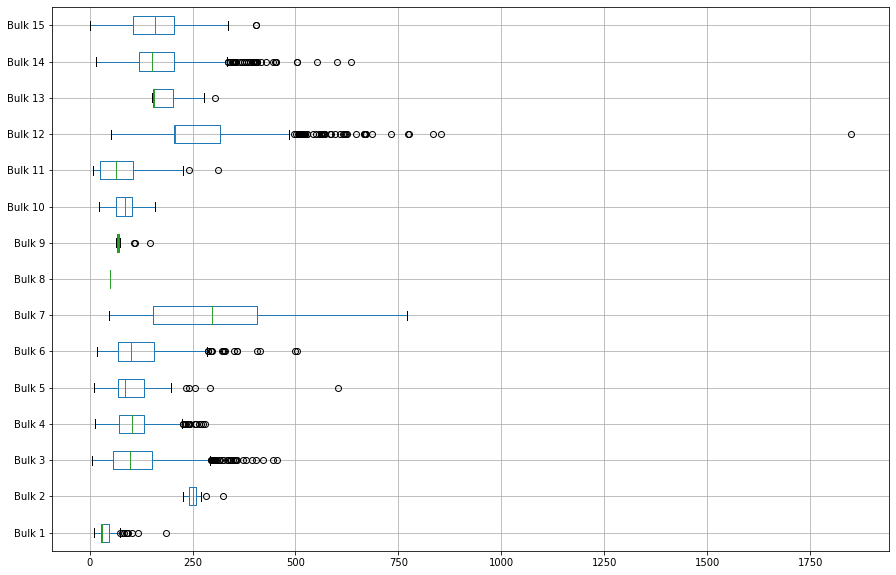

In [22]:
#Построим график с усами
data_bulk.boxplot([col for col in data_bulk.columns if col != 'key'], figsize=(15, 10), vert=False)

Почти в каждом сыпучем материале есть значение, похожее на выброс. Возможно, так устроен технологический процесс, не будем трогать эти значения.  
Сыпучий материал № 8 использовался всего один раз.

In [23]:
#Заполним пропуски нулями
data_bulk = data_bulk.fillna(0)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [24]:
#Суммируем все сыпучие материалы для каждой партии
data_bulk['bulk_sum'] = (data_bulk['Bulk 1'] + data_bulk['Bulk 2'] + data_bulk['Bulk 3'] + data_bulk['Bulk 4'] + 
                         data_bulk['Bulk 5'] + data_bulk['Bulk 6'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] + 
                         data_bulk['Bulk 9'] + data_bulk['Bulk 10'] + data_bulk['Bulk 11'] + data_bulk['Bulk 12'] +
                         data_bulk['Bulk 13'] + data_bulk['Bulk 14'] + data_bulk['Bulk 15'])

In [25]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


In [26]:
#Оставим в таблице только ключ и сумму сыпучих добавок
new_data_bulk = data_bulk.groupby('key').sum()[['bulk_sum']].reset_index()
new_data_bulk

,key,bulk_sum
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0
...,...,...
3124,3237,758.0
3125,3238,594.0
3126,3239,630.0
3127,3240,272.0


Переходим к следующей таблице

In [27]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3129 entries, 0 to 3128

Data columns (total 16 columns):

 #   Column   Non-Null Count  Dtype 

---  ------   --------------  ----- 

 0   key      3129 non-null   int64 

 1   Bulk 1   252 non-null    object

 2   Bulk 2   22 non-null     object

 3   Bulk 3   1298 non-null   object

 4   Bulk 4   1014 non-null   object

 5   Bulk 5   77 non-null     object

 6   Bulk 6   576 non-null    object

 7   Bulk 7   25 non-null     object

 8   Bulk 8   1 non-null      object

 9   Bulk 9   19 non-null     object

 10  Bulk 10  176 non-null    object

 11  Bulk 11  177 non-null    object

 12  Bulk 12  2450 non-null   object

 13  Bulk 13  18 non-null     object

 14  Bulk 14  2806 non-null   object

 15  Bulk 15  2248 non-null   object

dtypes: int64(1), object(15)

memory usage: 391.2+ KB


Пропуски во времени подачи сыпучих материалов совпадают с пропусками в объёме.

In [28]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Тип данных неверный, но т.к. эта таблица не понадобится для обучения, изменять ничего не будем.

In [29]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3239 entries, 0 to 3238

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   key     3239 non-null   int64  

 1   Газ 1   3239 non-null   float64

dtypes: float64(1), int64(1)

memory usage: 50.7 KB


In [30]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [31]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Пропусков нет, типы данных в порядке. В значениях аномалий не наблюдается. Построим графики, чтобы убедиться.

Text(0.5, 0, 'Значения')

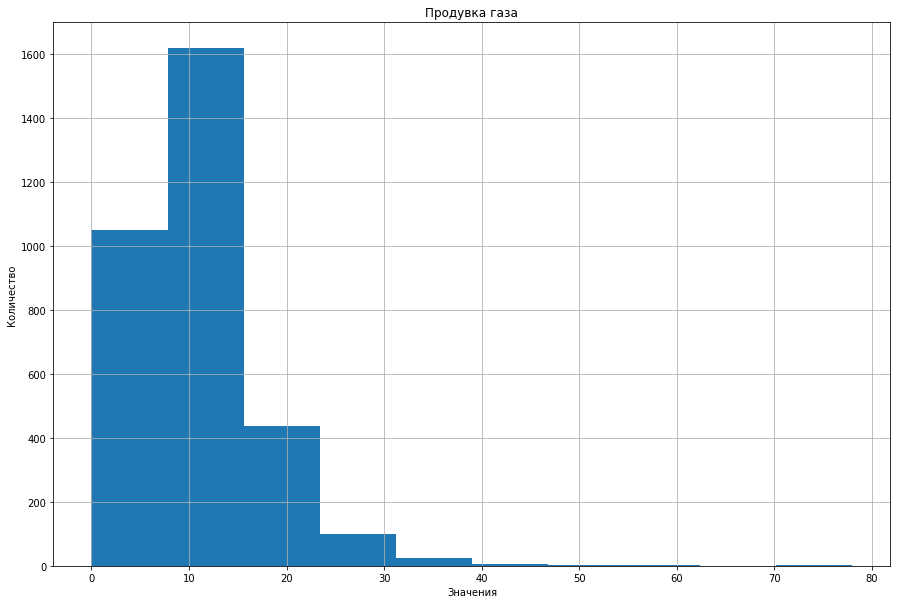

In [32]:
gas = data_gas['Газ 1'].hist(figsize=(15, 10))
gas.set_title('Продувка газа')
gas.set_ylabel('Количество')
gas.set_xlabel('Значения')

Есть значения, похожие на выбросы, но, может быть, это особенности технологического процесса. Оставим без изменений.

In [33]:
#Переименуем столбец
data_gas.columns = ['key', 'gas']
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Переходим к следующей таблице.

In [34]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 15907 entries, 0 to 15906

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   key           15907 non-null  int64  

 1   Время замера  15907 non-null  object 

 2   Температура   13006 non-null  float64

dtypes: float64(1), int64(1), object(1)

memory usage: 372.9+ KB


In [35]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [36]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Есть пропуски в значениях температуры, время замеров имеет неправильный тип данных, аномалий не наблюдается.

In [37]:
#Приведём даты к нужному типу
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [38]:
#Проверим результат
data_temp.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 15907 entries, 0 to 15906

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype         

---  ------        --------------  -----         

 0   key           15907 non-null  int64         

 1   Время замера  15907 non-null  datetime64[ns]

 2   Температура   13006 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1)

memory usage: 372.9 KB


Text(0.5, 0, 'Значения')

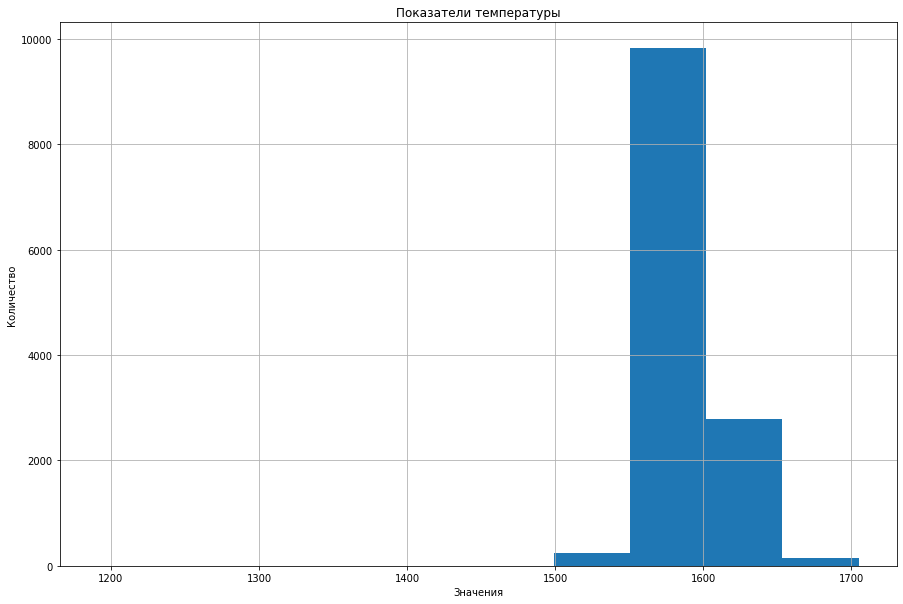

In [39]:
#Рассмотрим температуру
temp = data_temp['Температура'].hist(figsize=(15, 10))
temp.set_title('Показатели температуры')
temp.set_ylabel('Количество')
temp.set_xlabel('Значения')

In [40]:
#Посмотрим наименьшие значения температуры плавления
data_temp['Температура'].sort_values().head()

4350     1191.0
12564    1204.0
5978     1208.0
7958     1218.0
10127    1227.0
Name: Температура, dtype: float64

Судя по информации на сайте https://metal-holding.ua/, сталь плавится при температуре 1300-1500 градусов. Т.к. у нас есть значения ниже 1300 градусов, удалим их, это явные аномалии. Также удалим пустые строки, они могут плохо повлиять на обучение модели.

In [42]:
#Узнаем номера партий с температурой ниже нормальной
data_temp.sort_values(by=['Температура']).head(10)

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
12564,2561,2019-08-08 07:34:15,1204.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
10127,2052,2019-07-21 14:51:40,1227.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
8206,1671,2019-07-02 00:28:59,1519.0
2675,512,2019-05-22 11:08:02,1520.0
4561,908,2019-06-05 19:56:25,1520.0


In [44]:
data_temp[data_temp['key'] == 867]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0


Аномалия в первом замере, поэтому удалим всю партию

In [45]:
data_temp = data_temp.drop(data_temp[data_temp['key'] == 867].index)

In [46]:
data_temp[data_temp['key'] == 2561]

,key,Время замера,Температура
12564,2561,2019-08-08 07:34:15,1204.0
12565,2561,2019-08-08 07:35:02,NaN
12566,2561,2019-08-08 07:35:38,NaN
12567,2561,2019-08-08 07:49:07,NaN
12568,2561,2019-08-08 07:54:21,NaN
12569,2561,2019-08-08 07:56:57,NaN


Эту парти также нужно удалить, т.к. в ней известна только начальная температура.

In [47]:
data_temp = data_temp.drop(data_temp[data_temp['key'] == 2561].index)

In [48]:
data_temp[data_temp['key'] == 1214]

,key,Время замера,Температура
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0
5982,1214,2019-06-16 05:52:41,1608.0
5983,1214,2019-06-16 05:53:03,1608.0
5984,1214,2019-06-16 05:53:13,1608.0
5985,1214,2019-06-16 05:54:48,1604.0
5986,1214,2019-06-16 05:57:21,1604.0
5987,1214,2019-06-16 06:00:25,1604.0


Эту партию тоже удаляем

In [49]:
data_temp = data_temp.drop(data_temp[data_temp['key'] == 1214].index)

In [50]:
data_temp[data_temp['key'] == 1619]

,key,Время замера,Температура
7958,1619,2019-06-30 11:03:54,1218.0
7959,1619,2019-06-30 11:04:39,1623.0
7960,1619,2019-06-30 11:10:01,1611.0
7961,1619,2019-06-30 11:16:03,1603.0
7962,1619,2019-06-30 11:21:54,1590.0


И эту

In [51]:
data_temp = data_temp.drop(data_temp[data_temp['key'] == 1619].index)

In [52]:
data_temp[data_temp['key'] == 2052]

,key,Время замера,Температура
10127,2052,2019-07-21 14:51:40,1227.0
10128,2052,2019-07-21 14:52:21,1592.0
10129,2052,2019-07-21 15:06:31,1590.0
10130,2052,2019-07-21 15:15:24,1591.0
10131,2052,2019-07-21 15:24:06,1592.0


И эту тоже

In [53]:
data_temp = data_temp.drop(data_temp[data_temp['key'] == 2052].index)

In [54]:
#Проверим результат
data_temp.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 15869 entries, 0 to 15906

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype         

---  ------        --------------  -----         

 0   key           15869 non-null  int64         

 1   Время замера  15869 non-null  datetime64[ns]

 2   Температура   12973 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1)

memory usage: 495.9 KB


In [55]:
#Заменим пропуски на минусовое значение
data_temp = data_temp.fillna(-1000)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,-1000.0
15904,3241,2019-09-01 04:22:39,-1000.0
15905,3241,2019-09-01 04:33:42,-1000.0


In [56]:
#Посмотрим номера партии, у которых отрицательное значение температуры
t = data_temp.groupby('key')['Температура'].last().to_frame()
temp = t.loc[t.loc[:, 'Температура'] == -1000]
temp

,Температура
key,
2500,-1000.0
2501,-1000.0
2502,-1000.0
2503,-1000.0
2504,-1000.0
...,...
3237,-1000.0
3238,-1000.0
3239,-1000.0


Пропуски в температуре есть у партий, начиная с 2500 номера.

In [57]:
#Удалим все партии с пустыми строками
data_temp = data_temp.query('key < 2500')

In [58]:
#Проверим удаление
data_temp.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 12235 entries, 0 to 12266

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype         

---  ------        --------------  -----         

 0   key           12235 non-null  int64         

 1   Время замера  12235 non-null  datetime64[ns]

 2   Температура   12235 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1)

memory usage: 382.3 KB


<AxesSubplot:>

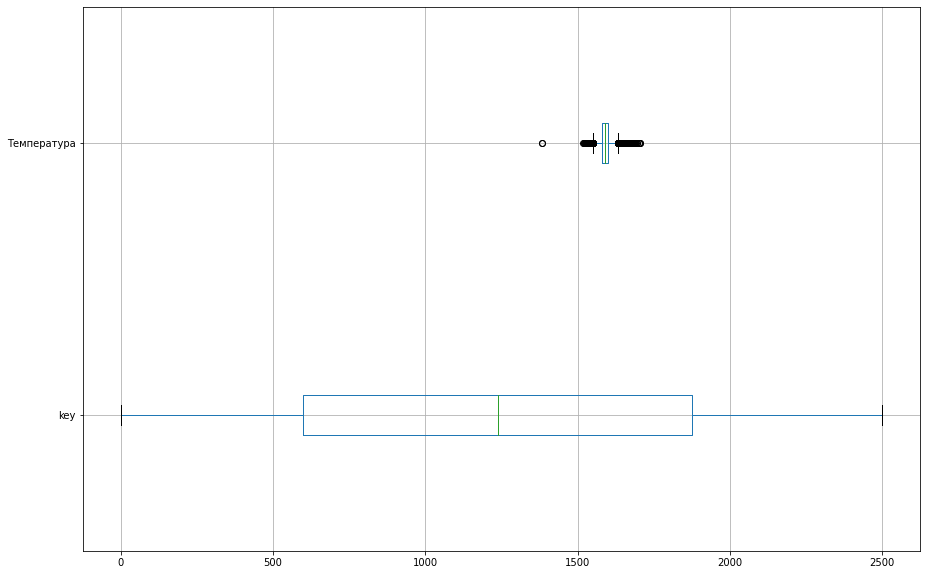

In [59]:
#Построим график с усами
data_temp.boxplot(figsize=(15, 10), vert=False)

In [60]:
data_temp['Температура'].sort_values().head()

8914    1383.0
8913    1383.0
8206    1519.0
2675    1520.0
4561    1520.0
Name: Температура, dtype: float64

В основном партии плавились при температуре от 1500 градусов. С температурой плавления 1300 есть только две партии. Очень похоже на выброс, но, опять таки, это может быть особенностью технологического процесса. Не будем их трогать.

Разделим температуру на начальную и конечную.

In [61]:
#Удалим партии, у которых только один замер температуры
one_t = data_temp.groupby('key')['Температура'].count().reset_index()
one_t['Температура'].value_counts()
one_t = one_t.loc[one_t['Температура'] == 1,'key']

In [62]:
new_data_temp = data_temp.copy()
new_data_temp = new_data_temp.drop(new_data_temp[new_data_temp['key'].isin(one_t.values)].index)

In [63]:
new_data_temp.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 12233 entries, 0 to 12266

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype         

---  ------        --------------  -----         

 0   key           12233 non-null  int64         

 1   Время замера  12233 non-null  datetime64[ns]

 2   Температура   12233 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1)

memory usage: 382.3 KB


Количество данных уменьшилось.

In [64]:
temp_one = new_data_temp.groupby('key').agg('min')['Время замера']
temp_one = pd.DataFrame(temp_one)
temp_one = temp_one.merge(new_data_temp, on='Время замера', how='left')
temp_one.set_axis(['time_one','key','temp_one'], axis = 'columns', inplace = True)

temp_two = new_data_temp.groupby('key').agg('max')['Время замера']
temp_two = pd.DataFrame(temp_two)
temp_two = temp_two.merge(new_data_temp, on='Время замера', how='left')
temp_two.set_axis(['time_two','key','temp_two'], axis = 'columns', inplace = True)

data_temp_new = temp_one.merge(temp_two, on='key', how='left')\
                  .reindex(columns=['key', 'time_one', 'temp_one', 'time_two', 'temp_two'])

In [65]:
data_temp_new.head()

,key,time_one,temp_one,time_two,temp_two
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


Температура разделена.

In [66]:
#Уберём из таблицы время
data_temp_new = data_temp_new.groupby('key').sum()[['temp_one', 'temp_two']].reset_index()
data_temp_new

,key,temp_one,temp_two
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2466,2495,1570.0,1591.0
2467,2496,1554.0,1591.0
2468,2497,1571.0,1589.0
2469,2498,1591.0,1594.0


Переходим к следующей таблице.

In [67]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3081 entries, 0 to 3080

Data columns (total 10 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   key     3081 non-null   int64  

 1   Wire 1  3055 non-null   float64

 2   Wire 2  1079 non-null   float64

 3   Wire 3  63 non-null     float64

 4   Wire 4  14 non-null     float64

 5   Wire 5  1 non-null      float64

 6   Wire 6  73 non-null     float64

 7   Wire 7  11 non-null     float64

 8   Wire 8  19 non-null     float64

 9   Wire 9  29 non-null     float64

dtypes: float64(9), int64(1)

memory usage: 240.8 KB


In [68]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Каждый проволочный материал был добавлен хотя бы один раз при плавке. Типы данных соответствуют значениям.

<AxesSubplot:>

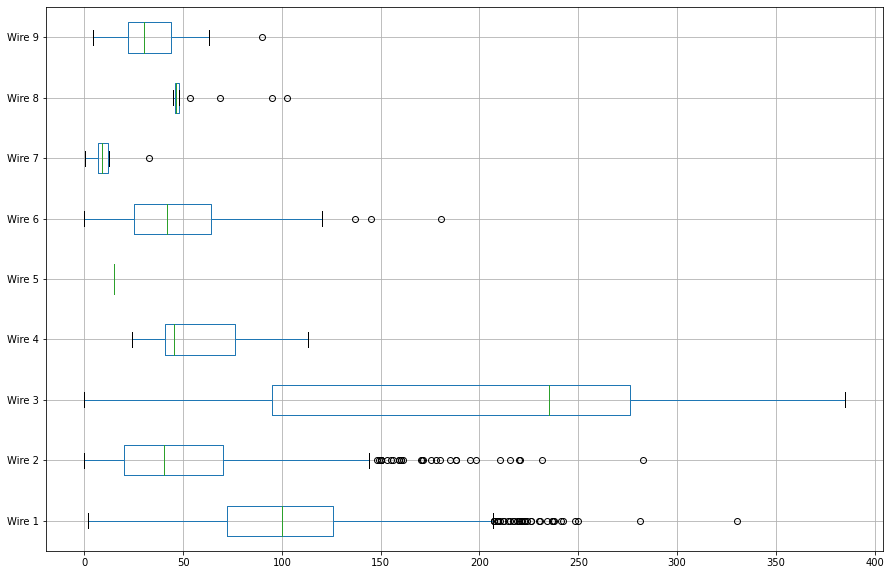

In [70]:
data_wire.boxplot([col for col in data_wire.columns if col != 'key'], figsize=(15, 10), vert=False)

Есть значения, похожие на выбросы, не будем их удалять. Скорее всего, таков технологический процесс.

In [71]:
#Заменим пустые значения на 0
data_wire = data_wire.fillna(0)

In [72]:
#Суммируем проволочные материалы
data_wire['wire_sum'] = (data_wire['Wire 1'] + data_wire['Wire 2'] + data_wire['Wire 3'] +
                         data_wire['Wire 4'] + data_wire['Wire 5'] + data_wire['Wire 6'] +
                         data_wire['Wire 7'] + data_wire['Wire 8'] + data_wire['Wire 9'])
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


In [73]:
new_data_wire = data_wire.groupby('key').sum()[['wire_sum']].reset_index()
new_data_wire

,key,wire_sum
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,98.352796
...,...,...
3076,3237,38.088959
3077,3238,56.128799
3078,3239,143.357761
3079,3240,34.070400


Идём к последней таблице

In [74]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3081 entries, 0 to 3080

Data columns (total 10 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   key     3081 non-null   int64 

 1   Wire 1  3055 non-null   object

 2   Wire 2  1079 non-null   object

 3   Wire 3  63 non-null     object

 4   Wire 4  14 non-null     object

 5   Wire 5  1 non-null      object

 6   Wire 6  73 non-null     object

 7   Wire 7  11 non-null     object

 8   Wire 8  19 non-null     object

 9   Wire 9  29 non-null     object

dtypes: int64(1), object(9)

memory usage: 240.8+ KB


In [75]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски во времени совпадают с пропусками в объёме проволочных материалов. Данная таблица нам не понадобится для обучения модели. Не будем её трогать.

### Объединение данных

In [76]:
#Объединим все таблицы в одну
data = data_temp_new.copy()
data = data.merge(new_data_arc, on='key')
data = data.merge(new_data_bulk, on='key')
data = data.merge(data_gas, on='key')
data = data.merge(new_data_wire, on='key')

In [77]:
data.head()

,key,temp_one,temp_two,power_full,heating_time,bulk_sum,gas,wire_sum
0,1,1571.0,1613.0,5.826395,1098,553.0,29.749986,60.059998
1,2,1581.0,1602.0,3.649216,811,582.0,12.555561,96.052315
2,3,1596.0,1599.0,2.989534,655,544.0,28.554793,91.160157
3,4,1601.0,1625.0,3.814962,741,595.0,18.841219,89.063515
4,5,1576.0,1602.0,4.035758,869,584.0,5.413692,98.352796


In [78]:
data

,key,temp_one,temp_two,power_full,heating_time,bulk_sum,gas,wire_sum
0,1,1571.0,1613.0,5.826395,1098,553.0,29.749986,60.059998
1,2,1581.0,1602.0,3.649216,811,582.0,12.555561,96.052315
2,3,1596.0,1599.0,2.989534,655,544.0,28.554793,91.160157
3,4,1601.0,1625.0,3.814962,741,595.0,18.841219,89.063515
4,5,1576.0,1602.0,4.035758,869,584.0,5.413692,98.352796
...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,3.986869,723,719.0,7.125735,89.150879
2321,2496,1554.0,1591.0,5.057033,940,796.0,9.412616,114.179527
2322,2497,1571.0,1589.0,2.885017,569,665.0,6.271699,103.134723
2323,2498,1591.0,1594.0,4.143749,750,733.0,14.953657,118.110717


Проверим данные на мультиколлинеарность.

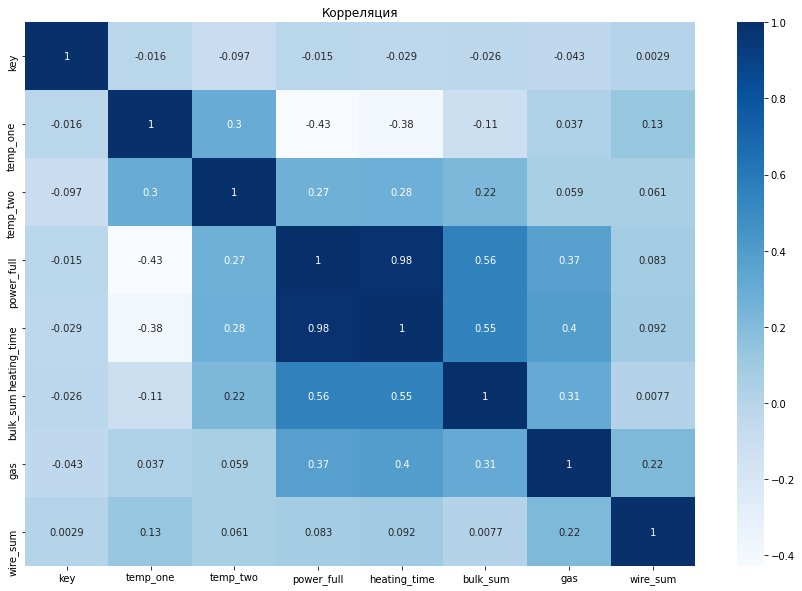

In [79]:
plt.figure(figsize=(15, 10))
plt.title('Корреляция')

sns.heatmap(data.corr(), annot = True, cmap="Blues")

plt.show()

Время нагрева и полная мощность очень сильно коррелирут между собой. Остальные признаки в пределах нормы. Удалим столбец "heating_time".

In [80]:
new_data = data.groupby('key').sum()[['temp_one', 'temp_two', 'power_full', 'bulk_sum', 'gas', 'wire_sum']].reset_index()
new_data

,key,temp_one,temp_two,power_full,bulk_sum,gas,wire_sum
0,1,1571.0,1613.0,5.826395,553.0,29.749986,60.059998
1,2,1581.0,1602.0,3.649216,582.0,12.555561,96.052315
2,3,1596.0,1599.0,2.989534,544.0,28.554793,91.160157
3,4,1601.0,1625.0,3.814962,595.0,18.841219,89.063515
4,5,1576.0,1602.0,4.035758,584.0,5.413692,98.352796
...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,3.986869,719.0,7.125735,89.150879
2321,2496,1554.0,1591.0,5.057033,796.0,9.412616,114.179527
2322,2497,1571.0,1589.0,2.885017,665.0,6.271699,103.134723
2323,2498,1591.0,1594.0,4.143749,733.0,14.953657,118.110717


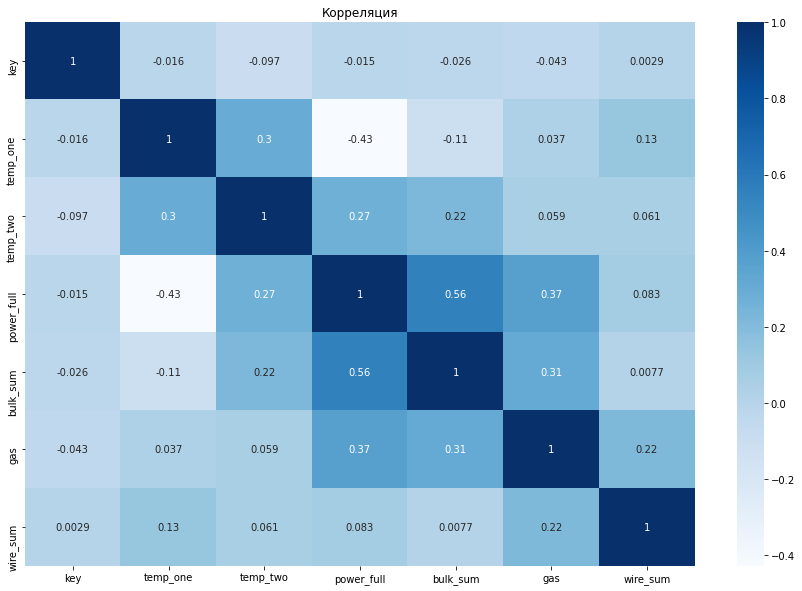

In [81]:
#Проверим ещё раз корреляцию
plt.figure(figsize=(15, 10))
plt.title('Корреляция')

sns.heatmap(new_data.corr(), annot = True, cmap="Blues")

plt.show()

Корреляция в пределах нормы. Переходим к этапу разделения данных.

In [82]:
#Проверим наличие пропусков
new_data.isna().sum()

key           0
temp_one      0
temp_two      0
power_full    0
bulk_sum      0
gas           0
wire_sum      0
dtype: int64

In [83]:
#Проверим наличие дубликатов
new_data.duplicated().sum()

0

### Вывод

В ходе исследования и предобработки данных было сделано следующее:  
* Данные загружены и изучены
* Выявлены и удалены аномалии в реактивной мощности и температуре
* Найдена полная мощность нагрева
* Температура разделена на начальную и конечную
* Данные из нескольких таблиц объединены в одну таблицу для удобства обучения модели
* Проведена проверка на корреляцию признаков, коррелирующий столбец удалён  
  
Данные поготовлены к обучению моделей.

## Разделение данных на выборки

In [84]:
random_state = 100423

features = new_data.drop(['key', 'temp_two'], axis=1)
target = new_data['temp_two']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv = 5

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 5)

(582, 5)

(1743,)

(582,)


Для обучения выберем следующие модели:  
* LinearRegression
* RandomForestRegressor
* LGBMRegressor

### Вывод

В ходе третьего этапа сделано:  
* Выделены признаки и целевой признак
* Данные разделены на тренировочную и тестовую выборки
* Выбраны три модели для обучения

## Обучение моделей

### LinearRegression

In [85]:
#Проведём масштабирование признаков
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [86]:
model_lr = LinearRegression()
cv_lr = (cross_val_score(model_lr, 
                         features_train, 
                         target_train, 
                         cv=cv, 
                         scoring='neg_mean_absolute_error').mean() * -1)
print('MAE линейной регрессии с кросс-валидацией:', cv_lr)

MAE линейной регрессии с кросс-валидацией: 6.781564446922313


МАЕ линейной регрессии с кросс-валидацией меньше 6.8 и составляет **6.78**, что отвечает поставленным требованиям. Рассмотрим другие модели.

### RandomForestRegressor

In [88]:
#Используем GridSearch для поиска лучших параметров

model_forest = RandomForestRegressor(random_state=random_state)

param_grid = {'n_estimators': [50, 100, 200, 400], 'max_depth' : [4, 6, 8, 10, 12]}

cv_forest = GridSearchCV(estimator=model_forest, 
                         param_grid=param_grid, 
                         scoring='neg_mean_absolute_error',  
                         cv=cv)

cv_forest.fit(features_train, target_train)


print('Лучшие параметры: ', cv_forest.best_params_)
print('Лучшая MAE: ', (-cv_forest.best_score_))

Лучшие параметры:  {'max_depth': 8, 'n_estimators': 400}

Лучшая MAE:  6.496190381729886


In [89]:
#Обучим модель с найденными параметрами
model_forest_best = RandomForestRegressor(random_state=random_state, max_depth=8, n_estimators= 400)
model_forest_best.fit(features_train, target_train)

model_forest_best_pred = model_forest_best.predict(features_train)

print('MAE случайного леса:', mean_absolute_error(target_train, model_forest_best_pred))

MAE случайного леса: 4.793208466206721


MAE случайного леса с кросс-валидацией тоже отвечает поставленным требованиям и составляет **4.79** на тренировочной выборке с лучшими гиперпараметрами, подобранными с помощью GridSearch. Рассмотрим ещё одну модель.

### LGBMRegressor

In [ ]:
#Подберём лучшие гиперпараметры для обучения

model_lg = LGBMRegressor(random_state=random_state)
params_gr = {'n_estimators': [50, 100, 200, 400], 'num_leaves': [50, 80, 100, 200], 'max_depth': [4, 6, 8, 10, 12]}

cv_lg = GridSearchCV(estimator=model_lg, param_grid=params_gr, scoring='neg_mean_absolute_error', cv=cv)

cv_lg.fit(features_train, target_train)

print('Лучшие параметры: ', cv_lg.best_params_)
print('Лучшая MAE: ', (-cv_lg.best_score_))

In [ ]:
#Обучим модель с найденными гиперпараметрами
model_lg_best = LGBMRegressor(random_state=random_state, max_depth=4, n_estimators=50, num_leaves=50)
model_lg_best.fit(features_train, target_train)
model_lg_best_pred = model_lg_best.predict(features_train)

print('MAE LGBMRegressor:', mean_absolute_error(target_train, model_lg_best_pred))

МАЕ LGBMRegressor с кросс-валидацией отвечает поставленным требованиям и составляет 6.52 на тренировочной выборке с лучшими гиперпараметрами, подобранными с помощью GridSearch.

### Вывод

Обучены три модели с применением кросс-валидации и подбором гиперпараметров:  
* **LinearRegression** - МАЕ = 6.78
* **RandomForestRegressor** - МАЕ = 4.79
* **LGBMRegressor** - МАЕ = 6.52  
  
По результатам обучения наименьшая МАЕ была получена у модели RandomForestRegressor. Её и будем тестировать.

## Тестирование модели

In [ ]:
#Узнаем МАЕ у модели RandomForestRegressor на тестовой выборке
model = RandomForestRegressor(random_state=random_state, max_depth=8, n_estimators= 400)
model.fit(features_train, target_train)
model_pred = model.predict(features_test)
print('MAE RandomForestRegressor: ', mean_absolute_error(target_test, model_pred))

МАЕ = **6.68**, что отвечает поставленным требованиям. Проведём анализ важности факторов на тестовой модели.

### Вывод

На тестовой выборке МАЕ получилась выше, чем на тренировочной, но полученное значение вошло в пределы нормы. Для тестирования были использованы гиперпараметры, полученные при обучении модели на тренировочной выборке.

## Анализ важности факторов

In [ ]:
#Построим график

features_forest = pd.Series(model.feature_importances_, features.columns)

fig, ax = plt.subplots(figsize=(16,14))
features_forest.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

### Вывод

Судя по построенному графику, наиболее важными признаками для итоговой метрики являются начальная температура и полная мощность нагрева. Заказчику стоит обратить на них внимание, т.к. они больше всего влияют на итоговую температуру.

## Общий вывод

В ходе исследования было сделано следующее:  
* Данные загружены, проанализированы и предобработаны
  * Выявлены и удалены аномалии в реактивной мощности и температуре
  * Найдена полная мощность нагрева
  * Температура разделена на начальную и конечную
  * Данные из нескольких таблиц объединены в одну таблицу для удобства обучения модели
  * Проведена проверка на корреляцию признаков, коррелирующий столбец удалён
* Выделены признаки и целевой признак для обучения моделей
* Данные разделены на тренировочную и тестовую выборки
* Обучены три модели:
  * **LinearRegression**
  * **RandomForestRegressor**
  * **LGBMRegressor**
* Для обучения модели использованись следующие признаки:
  * **temp_one**
  * **power_full**
  * **bulk_sum**
  * **gas**
  * **wire_sum**
* Выбрана одна модель для проверки на тестовой выборке - RandomForestRegressor с МАЕ = 4.79, полученной на тренировочной выборке
* Проведено тестирование лучшей модели. Получено значение МАЕ = 6.68, что подходит под требования (МАЕ < 6.8)
* Проанализирована важность признаков, на которых обучалась модель
  * Наиболее значимыми признаками оказались **начальная температура** и **полная мощность**
  * От этих признаков конечная температура (целевой признак) зависит сильнее всего
* Заказчику рекомендовано обратить внимание на наиболее важные признаки